# CINIC-10 conversions

CINIC-10 encapsulates CIFAR-10. Therfore, it has different uses associated with different tasks. This notebook shows how to pull CIFAR-10 from CINIC-10 (and validate that they're the same thing).

#### ENSURE THAT CINIC-10 IS DOWNLOADED AND STORED IN ../data/cinic-10

In [1]:
import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from shutil import copyfile
from PIL import Image
symlink = True    # If this is false the files are copied instead

## Recover CIFAR-10 from CINIC-10

In [2]:
cinic_directory = "../data/cinic-10"
cifar_directory = "../data/cinic-10-cifar"
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
sets = ['train', 'valid', 'test']
if not os.path.exists(cifar_directory):
    os.makedirs(cifar_directory)
if not os.path.exists(cifar_directory + '/train'):
    os.makedirs(cifar_directory + '/train')
if not os.path.exists(cifar_directory + '/test'):
    os.makedirs(cifar_directory + '/test')
    
for c in classes:
    if not os.path.exists('{}/train/{}'.format(cifar_directory, c)):
        os.makedirs('{}/train/{}'.format(cifar_directory, c))
    if not os.path.exists('{}/test/{}'.format(cifar_directory, c)):
        os.makedirs('{}/test/{}'.format(cifar_directory, c))

In [3]:
location_id_mapping_train = {}
location_id_mapping_test = {}
for s in sets:
    for c in classes:
        source_directory = '{}/{}/{}'.format(cinic_directory, s, c)
        filenames = glob.glob('{}/cifar*.png'.format(source_directory))
        for fn in filenames:
            dest_fn = fn.split('/')[-1]
            if 'train' in fn:
                dest_fn = '{}/train/{}/{}'.format(cifar_directory, c, dest_fn)
                if symlink:
                    if not os.path.islink(dest_fn):
                        os.symlink(fn, dest_fn)
                else:
                    copyfile(fn, dest_fn)
                location_id_mapping_train[int(fn.split('/')[-1].split('.')[0].split('-')[-1])] = dest_fn
                
            elif 'test' in fn:
                dest_fn = '{}/test/{}/{}'.format(cifar_directory, c, dest_fn)
                if symlink:
                    if not os.path.islink(dest_fn):
                        os.symlink(fn, dest_fn)
                else:
                    copyfile(fn, dest_fn)
                    
                location_id_mapping_test[int(fn.split('/')[-1].split('.')[0].split('-')[-1])] = dest_fn

### Check whether the pytorch data loader's cifar-10 matches CINIC-10's version

In [4]:
pytorch_cifar_train = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('../data/Cifar-10',
                                 train=True,
                                 download=True,
                                 transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=50000, shuffle=False)

Files already downloaded and verified


In [5]:
cinic_cifar_train = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cifar_directory + '/test/',
                                     transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=10, shuffle=False)

In [6]:
for batch_idx, (inputs, targets) in enumerate(pytorch_cifar_train):
    break
cifar_original_data = np.transpose(inputs.numpy(), (0,2,3,1))

Change the index variable below to check other images. 

Difference: 0.0


Text(0.5,1,'From CINIC-10')

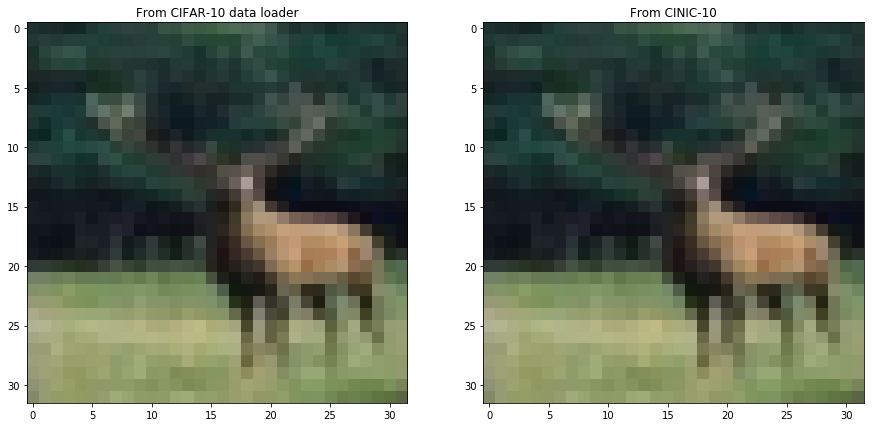

In [7]:
index_to_check = 343
cifar_img = cifar_original_data[index_to_check]*255
cinic_10_img = np.array(Image.open(location_id_mapping_train[index_to_check]))

difference = np.sqrt(np.sum((cifar_img - cinic_10_img)**2))
print('Difference: {}'.format(difference))

fig = plt.figure(figsize = (15,7))
ax1 = fig.add_subplot(121)
ax1.imshow(cifar_img.astype(int))
ax1.set_title('From CIFAR-10 data loader')
ax2 = fig.add_subplot(122)
ax2.imshow(cinic_10_img)
ax2.set_title('From CINIC-10')


## Now to compare CIFAR-10 images with CINIC-10 images
Considering that most of CINIC-10 is made up of images downsampled from the [Imagenet database](http://image-net.org/), below we sample from each of these for a qualitative comparison.

In [8]:
images_per_row = 20
images_per_col = 10

In [9]:
cifar_train = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('../data/Cifar-10',
                                 train=True,
                                 download=True,
                                 transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=50000, shuffle=True)

Files already downloaded and verified


In [10]:
cinic_train = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/train',
                                     transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=50000, shuffle=True)

In [11]:
all_cinic = {}
all_cifar = {}
for batch_id, ((cinic_imgs, cinic_targets), (cifar_imgs, cifar_targets)) in enumerate(zip(cinic_train, cifar_train)):
    print('Shapes before: ', cinic_imgs.shape, cifar_imgs.shape)
    cinic_imgs = np.transpose(cinic_imgs.numpy(), (0,2,3,1))
    cifar_imgs = np.transpose(cifar_imgs.numpy(), (0,2,3,1))
    print('Shapes after: ', cinic_imgs.shape, cifar_imgs.shape)
    
    for target in range(10):
        cinic_img = np.squeeze(cinic_imgs[np.nonzero(cinic_targets==target)][0:images_per_row*images_per_col])
        cifar_img = np.squeeze(cifar_imgs[np.nonzero(cifar_targets==target)][0:images_per_row*images_per_col])
        output_img_cinic = np.ones(shape=(images_per_col * 33 + 1, images_per_row * 33 + 1, 3))
        output_img_cifar = np.ones(shape=(images_per_col * 33 + 1, images_per_row * 33 + 1, 3))
    
        for i in range(images_per_row*images_per_col):
            xi, yi = np.unravel_index(i, (images_per_col, images_per_row))
            xi *= 33
            xi += 1
            yi *= 33
            yi += 1
            output_img_cinic[xi:xi+32, yi:yi+32,:] = cinic_img[i]
            output_img_cifar[xi:xi+32, yi:yi+32,:] = cifar_img[i]
        all_cinic[target] = output_img_cinic
        all_cifar[target] = output_img_cifar
    break

Shapes before:  torch.Size([50000, 3, 32, 32]) torch.Size([50000, 3, 32, 32])
Shapes after:  (50000, 32, 32, 3) (50000, 32, 32, 3)


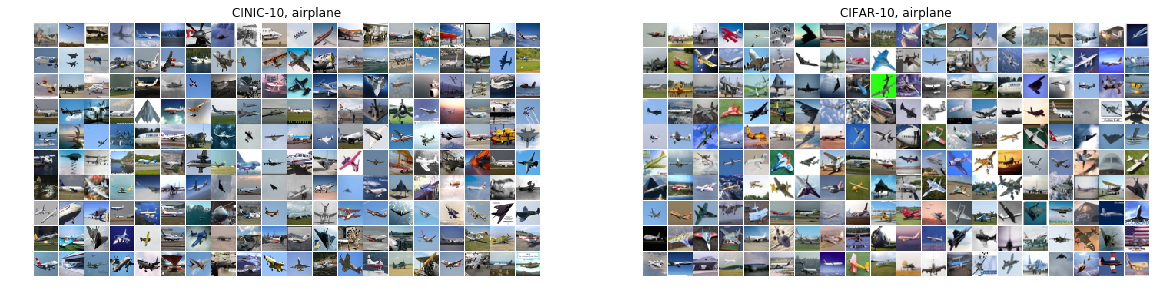

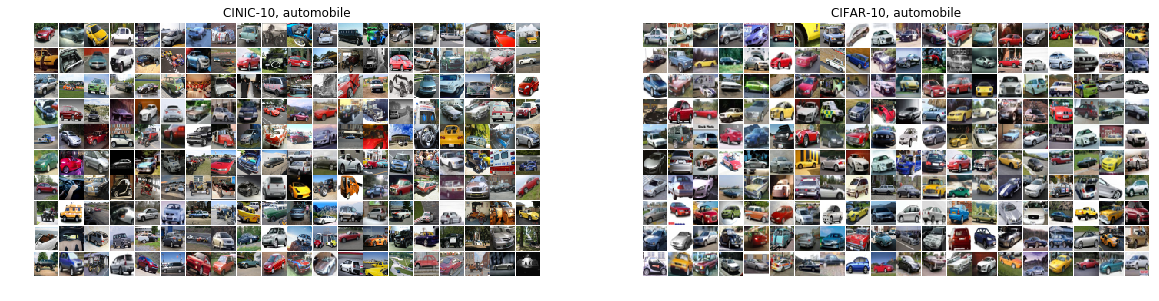

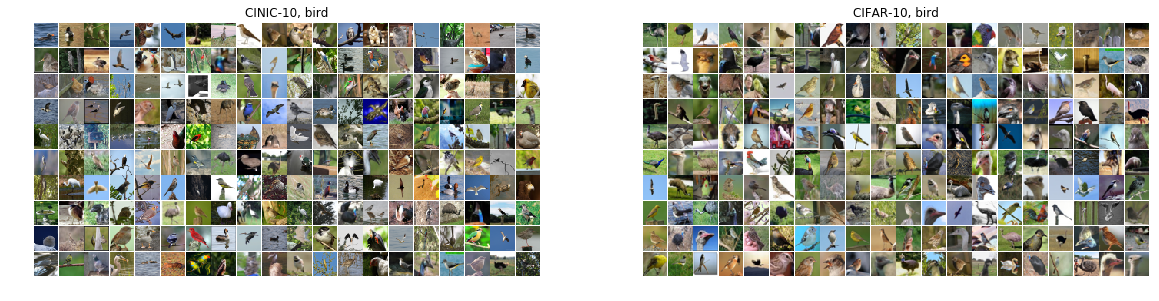

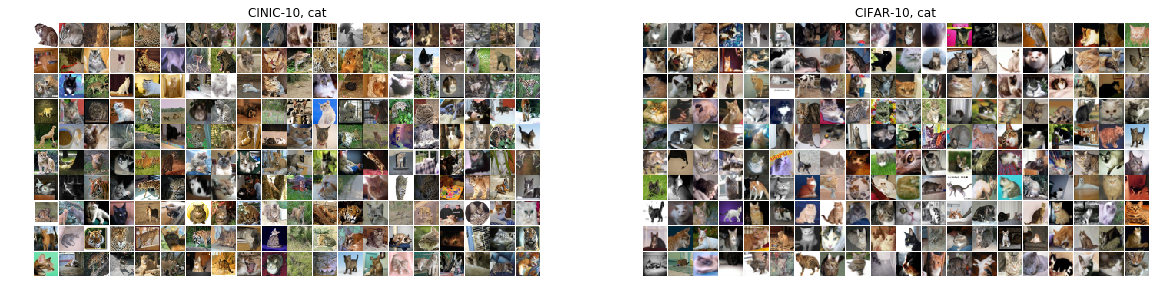

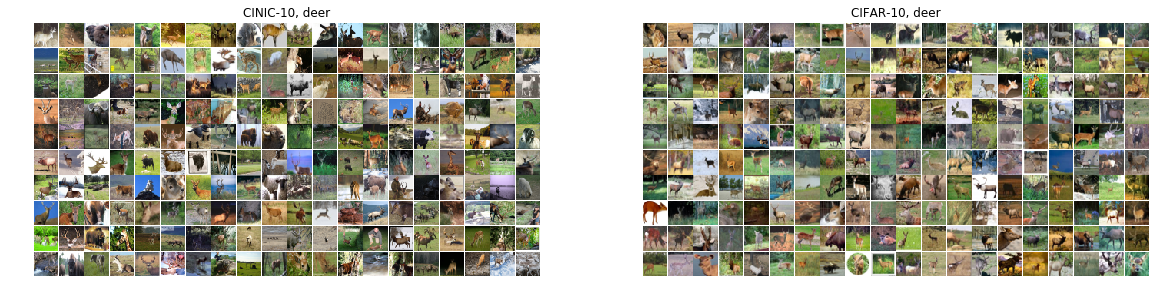

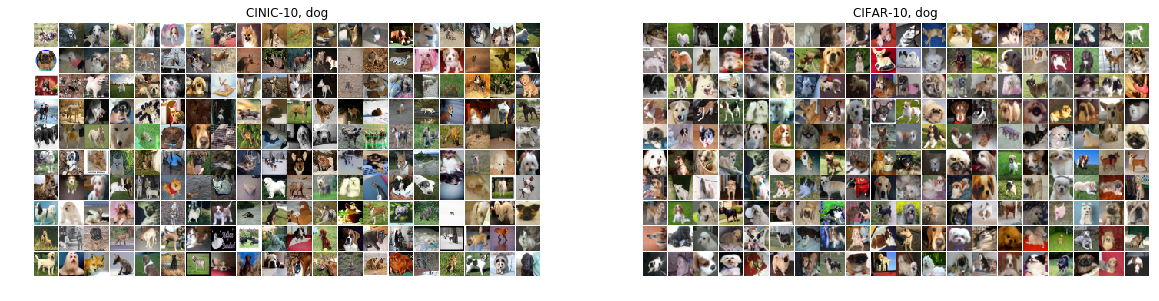

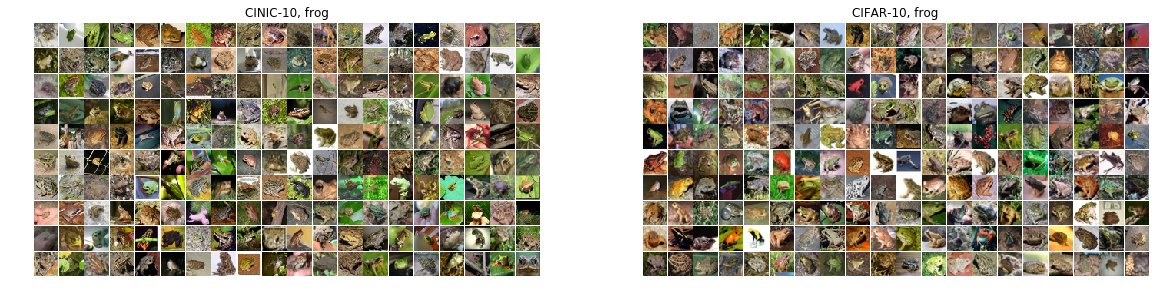

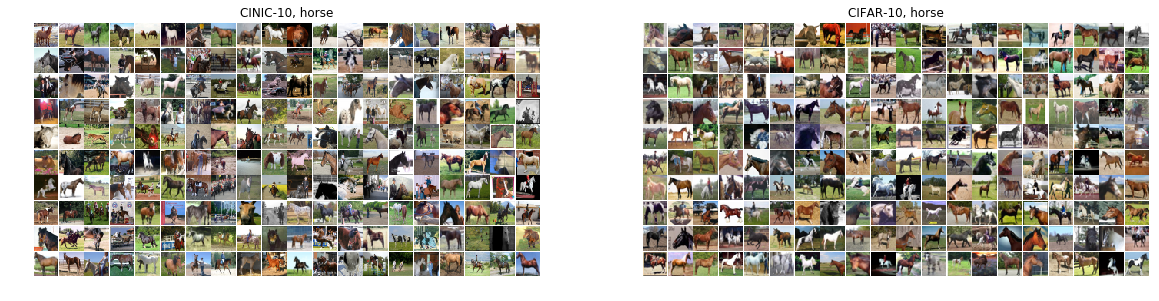

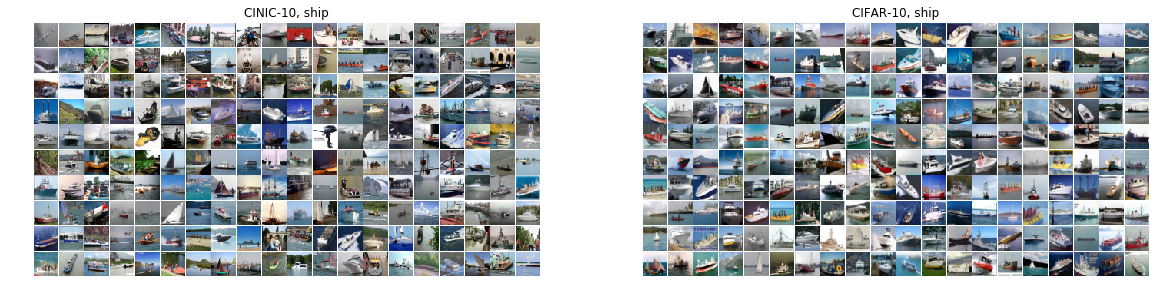

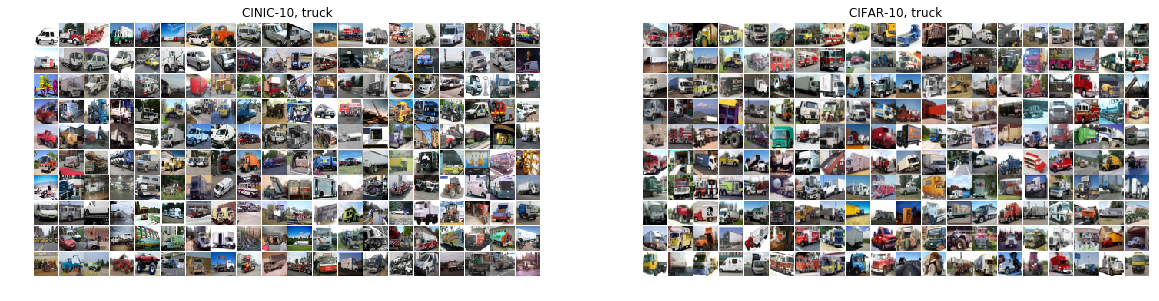

In [12]:
for i in range(10):
    c = classes[i]
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(121)
    ax1.imshow(all_cinic[i])
    ax1.axis('off')
    ax1.set_title('CINIC-10, {}'.format(c))
    cinic = Image.fromarray((all_cinic[i] * 255).astype(np.uint8))
    cinic.save('../images/cinic-{}.png'.format(c))
    ax2 = fig.add_subplot(122)
    ax2.imshow(all_cifar[i])
    ax2.axis('off')
    ax2.set_title('CIFAR-10, {}'.format(c))
    cifar = Image.fromarray((all_cifar[i] * 255).astype(np.uint8))
    cifar.save('../images/cifar-{}.png'.format(c))
